In [2]:
import json
import os
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import random
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torch
import re

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def create_data_list(image_dir, gt_dir):
    data_list = []
    
    for gt_file in os.listdir(gt_dir):
        with open(os.path.join(gt_dir, gt_file), 'r') as file:
            lines = file.readlines()
            category = os.path.splitext(gt_file)[0]
            for line in lines:
                image_name = line.strip() + '.jpg'
                image_path = os.path.join(image_dir, image_name)
                if os.path.exists(image_path):
                    data_list.append((image_path, category))

    return data_list

In [4]:
# Определите пути к папкам с изображениями и текстовыми файлами
image_dir = '/kaggle/input/oxford5k-dataset/oxbuild_images'
gt_dir = '/kaggle/input/oxford5k-dataset/gt_files_170407'

# Создание списка данных
data_list = create_data_list(image_dir, gt_dir)

# Теперь data_list содержит пары (путь к изображению, категория)
print("Количество элементов в data_list:", len(data_list))

Количество элементов в data_list: 4335


In [5]:
def extract_class_name(label):
    # Извлекаем первые одно или два слова до числа или '_'
    match = re.match(r'([a-zA-Z]+(?:_[a-zA-Z]+)?)', label)
    return match.group(1) if match else None

classes = [extract_class_name(label) for _, label in data_list]

In [6]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(classes)

encoded_data_list = [(data_list[i][0], encoded_labels[i]) for i in range(len(data_list))]

In [7]:
# Для воспроизводимости результатов зафиксируем сиды:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [8]:
# Определение класса датасета
class CustomDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        image_path, label = self.data_list[idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image, label

# Трансформация изображений
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
dataset = CustomDataset(encoded_data_list, transform=transform)
# Создание датасетов
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
# Создание даталоадеров
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
from torchvision.models import resnet50, ResNet50_Weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet50(weights=ResNet50_Weights.DEFAULT).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 172MB/s] 


In [10]:
fc_new = nn.Linear(in_features=2048, out_features=11, bias=True)
model.fc = fc_new

In [11]:
# Заблокируем подсчет весов для всех слоёв
for param in model.parameters():
    param.requires_grad = False

In [12]:
# Разблокируем первый сверточный слой и классификатор
model.conv1.weight.requires_grad = True
model.fc.weight.requires_grad = True

In [13]:
loss_func = nn.CrossEntropyLoss().to(device) #Функция потерь

opt = optim.Adam(model.parameters(), lr=0.001) # Адам-оптимизатор
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=5, gamma=0.1)

In [14]:
def train(model, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0

    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = correct_predictions.double() / len(data_loader.dataset)

    return epoch_loss, epoch_acc

In [15]:
def validate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = correct_predictions.double() / len(data_loader.dataset)

    return epoch_loss, epoch_acc

In [16]:
num_epochs = 5
model = model.to(device)
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, loss_func, opt, device)
    valid_loss, valid_acc = validate(model, test_loader, loss_func, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_acc.item())
    valid_accuracies.append(valid_acc.item())

    print(f"Эпоха {epoch+1}/{num_epochs}")
    print(f"Обучение - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    print(f"Валидация - Loss: {valid_loss:.4f}, Accuracy: {valid_acc:.4f}")


Эпоха 1/5
Обучение - Loss: 1.0345, Accuracy: 0.6918
Валидация - Loss: 0.6804, Accuracy: 0.8420
Эпоха 2/5
Обучение - Loss: 0.4241, Accuracy: 0.9037
Валидация - Loss: 0.4104, Accuracy: 0.9020
Эпоха 3/5
Обучение - Loss: 0.2604, Accuracy: 0.9527
Валидация - Loss: 0.2552, Accuracy: 0.9354
Эпоха 4/5
Обучение - Loss: 0.2159, Accuracy: 0.9550
Валидация - Loss: 0.2324, Accuracy: 0.9423
Эпоха 5/5
Обучение - Loss: 0.1626, Accuracy: 0.9686
Валидация - Loss: 0.1770, Accuracy: 0.9504


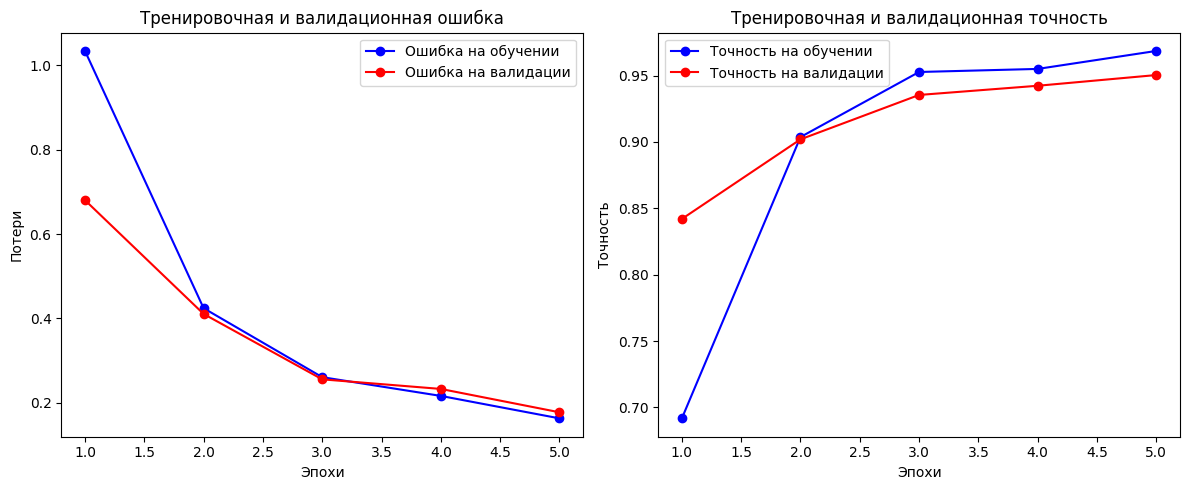

In [17]:
import matplotlib.pyplot as plt
# Количество эпох - ось X для графиков
epochs = range(1, len(train_losses) + 1)

# График потерь
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Ошибка на обучении')
plt.plot(epochs, valid_losses, 'ro-', label='Ошибка на валидации')
plt.title('Тренировочная и валидационная ошибка')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'bo-', label='Точность на обучении')
plt.plot(epochs, valid_accuracies, 'ro-', label='Точность на валидации')
plt.title('Тренировочная и валидационная точность')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
model.eval()
y_true_list = []
y_pred_list = []
correct = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        image_batch, label_batch = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        label_batch = torch.flatten(label_batch).type(torch.LongTensor)
        outputs = model(image_batch)
        predicted = torch.argmax(outputs, dim=1)
        predicted = predicted.cpu()
        y_true_list.append(label_batch.numpy())
        y_pred_list.append(predicted.numpy())
        
        total += label_batch.size(0)
        correct += (predicted == label_batch).sum().item()


print(f"Точность модели на test: {100 * correct / total:.2f} %")

Точность модели на test: 95.04 %


In [19]:
def get_all_predictions(model, data_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_predictions, all_labels

# Получение предсказаний и меток
predictions, labels = get_all_predictions(model, test_loader, device)

In [20]:
from sklearn.metrics import classification_report

print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       134
           1       1.00      1.00      1.00        32
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        23
           4       0.97      0.98      0.97       126
           5       0.93      0.81      0.87        16
           6       1.00      1.00      1.00        67
           7       1.00      1.00      1.00        11
           8       1.00      0.93      0.96        94
           9       1.00      1.00      1.00         7
          10       0.94      0.97      0.95       343

    accuracy                           0.95       867
   macro avg       0.97      0.96      0.97       867
weighted avg       0.95      0.95      0.95       867



In [21]:
import random
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

def imshow(ax, img):
    img = img / 2 + 0.5  # денормализация
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))

def visualize_model(dataloader, model, num_images=10):
    model.eval()
    images, labels = [], []
    
    # Сбор изображений и меток
    for inputs, labels_batch in dataloader:
        images.extend(inputs)
        labels.extend(labels_batch)
        if len(images) >= num_images:
            break

    # Рандомный выбор изображений
    indices = random.sample(range(len(images)), num_images)
    selected_images = [images[i] for i in indices]
    selected_labels = [labels[i] for i in indices]

    # Визуализация
    fig = plt.figure(figsize=(16, 16))
    grid = ImageGrid(fig, 111, nrows_ncols=(2, num_images // 2 + num_images % 2), axes_pad=0.05)

    for i, (img, label) in enumerate(zip(selected_images, selected_labels)):
        ax = grid[i]
        img = img.to(device)
        label = label.to(device)
        output = model(img.unsqueeze(0))
        _, pred = torch.max(output, 1)

        imshow(ax, img.cpu())
        ax.text(10, 210, f'Prediction: {pred.item()}\nReal Label: {label.item()}', 
                color='k', backgroundcolor='w', alpha=0.8)

    plt.show()

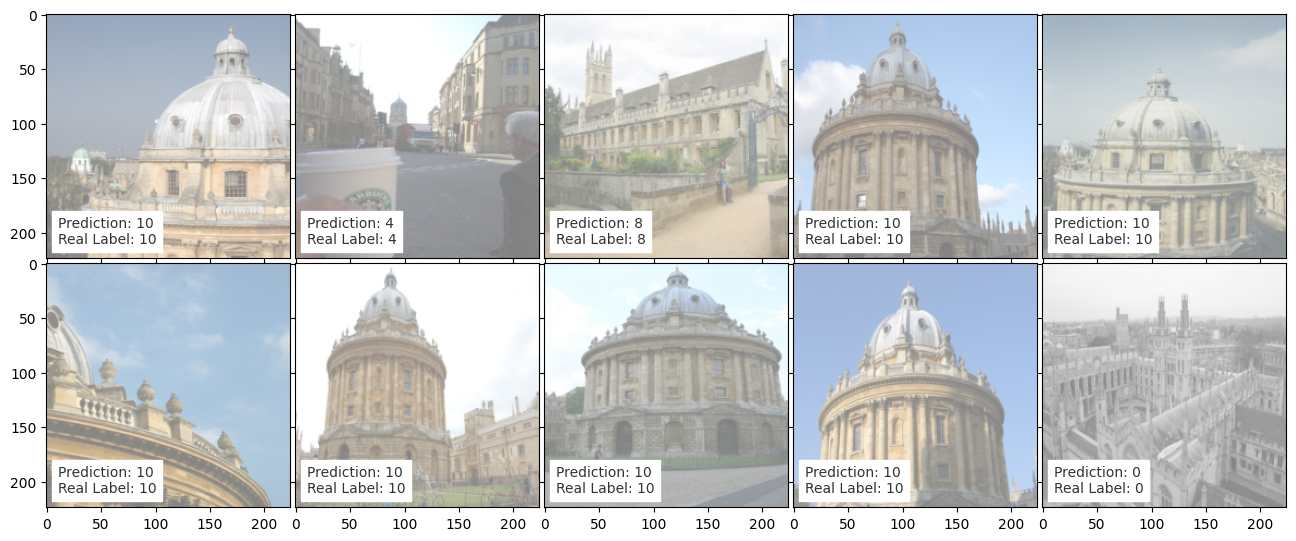

In [22]:
visualize_model(test_loader, model)

In [23]:
torch.save(model.state_dict(), 'classification_with_junk.pth')